In [13]:
%reset


import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import netCDF4 as nc
import numpy as np
import scipy as sp

import seawater
import datetime as dt
""
from salishsea_tools import (
    nc_tools,
    viz_tools,
    geo_tools,
    tidetools
)

# matplotlib.use('Agg')
# plt.style.use('seaborn-whitegrid')
import cmocean as cm
import glob
import sys
# sys.path.append('/data/tjarniko/mocsy')
# sys.path.append('/data/tjarniko/MEOPAR/at3/notebooks/carbon_dev/CCCmaDEV/CCCma_src')
# import mocsy
# import CCCma
# import CCCma_stations as cs

from scipy import optimize
import arrow
import gsw
import pandas as pd
import xarray as xr
%matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [14]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Annotation: original intrusion code

Summary: Uses a derived relationship between potential density (sigma0) and cfc-freon11 estimated watermass age to determine what atmospheric co2 the watermass saw when it was last at surface. Calculates pco2 'intrusion' = (witnessed atm co2 - preindustrial atm co2). Calculates present-day pco2 of the watermass (at in-situ pressure) and subtracts this intrusion to get preindustrial pco2. The assumption is that the present-day watermass has taken up all the 'extra' [witnessed-preindustrial] pco2, and that the preindustrial watermass would not have taken this pco2 up, and thus would be lower by the intrusion amount. The method then calculates preindustrial DIC from this derived preindustrial pco2, keeping TA, S, T constant.
Saves preindustrial DIC, and some intermediate values, to a netcdf.

## Steps:

###### 1. Opens a LiveOcean netcdf file and calculates pot. density from votemper and vosaline
    
######  2.  Uses a derived relationship between potential density (sigma0) and cfc-freon11 estimated watermass age to determine what atmospheric co2 the watermass saw when it was last at surface. 
    
######  3. Calculates pco2 'intrusion' = (witnessed atm co2 - preindustrial atm co2)
 
 Eg: A watermass that is 50 years old will have seen ~350 uatm co2, so ~70 uatm more than a preindustrial one. To make boundary conditions for a preindustrial watermass that of the same density, we assume that the  preindustrial watermass absorbed ~70 uatm less uatm co2. This assumes the watermass was in equilibrium with the atmosphere when it was at the surface (an incorrect assumption...)
 
###### 4. Calculates in-situ present-day pco2 using mocsy, subtracts intrusion from present-day pco2 to get preindustrial pco2

###### 5. Iteratively finds preindustrial DIC corresponding to preindustrial pco2

###### 6. NetCDF format: saves these variables in './preind_DIC/LO_intrusion_' + datestr +'_preind_DIC.nc' 

    Variables saved: 
    sigma0 
    pycnal_last_at_surface 
    pycnal_witnessed_atm_co2 
    insitu_pco2 
    preind_pco2 
    preind_dic
 

In [15]:
def find_nearest(array, value):
    
    import numpy as np
    
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

def find_DIC_corresp_to_pco2(tsal, ttemp, tpco2, tta, pres_atm, depth_this):
    
    import numpy as np
    import mocsy
    
    steps = 10000
    tsal_r = np.zeros([steps])
    tsal_r[:] = tsal
    ttemp_r = np.zeros([steps])
    ttemp_r[:] = ttemp
    tta_r = np.zeros([steps])
    tta_r[:] = tta * 1e-3
    tpres_r = np.zeros([steps])
    tpres_r[:] = pres_atm
    depth_r = np.zeros([steps])
    depth_r[:] = depth_this
    tzero = np.zeros([steps])

    end_d = 2400
    start_d = 600
    intvl = (end_d - start_d)/steps
    tdic_r = np.arange(start_d,end_d-0.1,intvl) * 1e-3
    
    response_tup = mocsy.mvars(temp=ttemp_r, sal=tsal_r, alk=tta_r, dic=tdic_r, 
                       sil=tzero, phos=tzero, patm=tpres_r, depth=depth_r, lat=tzero, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup    
    
    diffmat = pco2 - tpco2
    idx, ans = find_nearest( diffmat,0 )
    
   # if ans> 2:
   #     print('Danger, pco2 found >2 uatm from pco2 given')
    fin_dic = tdic_r[idx]*1e3
    
    return fin_dic

def oned_moxy(tsal, ttemp, tdic, tta, pres_atm, depth_this):
    import sys
    sys.path.append('/data/tjarniko/mocsy')
    import mocsy
    import numpy as np
    import gsw
    
    size_box = np.shape(tdic)
    size_0 = size_box[0]
    size_1= size_box[1]

    tsra = np.ravel(tsal)
    ttera = np.ravel(ttemp)
    ttara = np.ravel(tta) * 1e-3
    tdra = np.ravel(tdic) * 1e-3
    tzero = np.zeros_like(tsra)
    tpressure = np.zeros_like(tsra)
    #tdepth = np.zeros_like(tsra)
    tpressure[:] = pres_atm
    tdepth = np.ravel(depth_this)
    tzero = tpressure * 0 
        
    tsra_psu = tsra*35/35.16504
    ttera_is = gsw.t_from_CT(tsra,ttera,tzero)

    response_tup = mocsy.mvars(temp=ttera_is, sal=tsra_psu, alk=ttara, dic=tdra, 
                       sil=tzero, phos=tzero, patm=tpressure, depth=tdepth, lat=tzero, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

    pHr = pH.reshape(size_0,size_1)
    OmAr = OmegaA.reshape(size_0,size_1)
    pco2r = pco2.reshape(size_0,size_1)
    
    return pHr, OmAr, pco2r

def co2_from_year(year):
    import pandas as pd
    '''takes a value for a year, converts year to int,
    and finds appropriate co2 values  from pandas lookup table. 
    if year < 1832, value is for year 1832, if year > 2018, value is for year 2018'''
    co2_rec = pd.read_csv('lawdome_maunaloa.csv') 
    whole_year = int(year)
    
    if whole_year >= 2018:
        whole_year = 2018     
        #('year > 2018, using value for 2018')
        
    if whole_year <= 1832:
        whole_year = 1832
        #('year < 1832, using value for 1832')

    match = (co2_rec['YEAR'] == whole_year) 
    atmco2 = co2_rec['PPMCO2'][match]
    t_co2 = atmco2.values[0]
    return t_co2


def calc_preind_co2_intrusion_method(ncname, datestr):
    import numpy as np
    import netCDF4 as nc
    import gsw
    
    """
    - Opens a LiveOcean netcdf file
    - Calculates potential density
    - Uses a derived relationship between potential density (sigma0) and 
    cfc-freon11 estimated watermass age to determine what atmospheric co2
    the watermass saw when it was last at surface. 
    - Then calculates pco2 intrusion = (witnessed atm co2 - preindustrial atm co2)
    - Then calculates in-situ present-day pco2 using mocsy
    - Then subtracts intrusion from present-day pco2 to get preindustrial pco2
    - Then iteratively finds preindustrial DIC corresponding to preindustrial pco2
    - Saves these variables in './preind_DIC/LO_intrusion_' + datestr +'_preind_DIC.nc' 
    
    Parameters
    ----------
    ncname : name of path + filename of LiveOcean boundary condition file
    for SalishSeaCast, containing temperature, salinity, DIC, TA
    datestr : a string of form y2018m06d01 to write in resulting netcdf name.
    
    Returns
    -------
    writes netcdf file of form ./preind_DIC/LO_intrusion_' + datestr +'_preind_DIC.nc
    with the following variables:
    sigma0, pycnal_last_at_surface, pycnal_witnessed_atm_co2
    insitu_pco2, preind_pco2, preind_dic
    """    
    print(datestr)
    #open dataset & retrieve relevant variables, calculate potential density
    test_LO = nc.Dataset(ncname)
    zlevels = (test_LO['deptht'][:])
    sal = test_LO['vosaline'][0,:,0,:]
    temp = test_LO['votemper'][0,:,0,:]
    sigma0 = gsw.sigma0(sal,temp)
    DIC = test_LO['DIC'][0,:,0,:]
    TA = test_LO['TA'][0,:,0,:]
    depth_this = np.zeros_like(TA)
    #depth_this - array of depths of same shape as DIC
    for i in range(0,950):
        depth_this[:,i] = zlevels
    
    #calculate pycnal's last surfacing, according to exp function
    #found using cfc ages
    params0 = 0.1301889490932413
    params1 = 3.8509914822057825
    params2 = 8.301166081413104
    pycnal_last_at_surface = 2019 - (params0 *np.exp(-params1*(25.15-sigma0))+params2)

    #find last seen atmospheric co2
    pycnal_witnessed_atm_co2 = np.zeros_like(pycnal_last_at_surface)
    for i in range(0,40):
        for j in range(0,950):
            ty = pycnal_last_at_surface[i,j]
            tco2 = co2_from_year(ty)
            pycnal_witnessed_atm_co2[i,j] = tco2
            
    #calculate pco2 intrusion - how much 'extra' co2 did this pycnal
    #see, compared to preindustrial levels?
    pycnal_intrusion = pycnal_witnessed_atm_co2 - 284
    
    print('calculate parcel in-situ pco2')
    #calculate parcel's in-situ pco2
    pHr, OmAr, pco2r = oned_moxy(sal, temp, DIC, TA, 1, depth_this)
    insitu_pco2 = pco2r.reshape(40,950)
    
    #calculate preindustrial pco2 = insitu_pco2 - intrusion
    preind_pco2 = insitu_pco2 - pycnal_intrusion
    
    #calculate preindustrial DIC iteratively
    preind_dic = np.zeros_like(DIC)
    preind_dic_r = np.ravel(preind_dic)
    pco2r_preind_r = np.ravel(preind_pco2)
    depth_r = np.ravel(depth_this)
    sal_r = np.ravel(sal)
    temp_r = np.ravel(temp)
    DIC_r = np.ravel(DIC)
    TA_r = np.ravel(TA)
    
    print('calculating preindustrial DIC')
    for i in range(0,len(depth_r)):
        if i%950 == 0:
            print(i)
        t_dic = find_DIC_corresp_to_pco2(sal_r[i], temp_r[i], pco2r_preind_r[i], TA_r[i], 1, depth_r[i])
        preind_dic_r[i] = t_dic
    preind_dic = preind_dic_r.reshape(40,950)
    
    f = nc.Dataset('./preind_DIC/LO_intrusion_' + datestr +'_preind_DIC.nc','w', format='NETCDF4') #'w' stands for write
    g = f.createGroup('preindustrial_DIC')
    g.createDimension('xval', 950)
    g.createDimension('depth', 40)
    ts = g.createVariable('sigma0','f4',('depth','xval'))
    ts[:] = sigma0
    ts2 = g.createVariable('pycnal_last_at_surface','f4',('depth','xval'))
    ts2[:] = pycnal_last_at_surface
    ts3 = g.createVariable('pycnal_witnessed_atm_co2','f4',('depth','xval'))
    ts3[:] = pycnal_witnessed_atm_co2
    ts4 = g.createVariable('insitu_presday_pco2','f4',('depth','xval'))
    ts4[:] = insitu_pco2
    ts5 = g.createVariable('preind_pco2','f4',('depth','xval'))
    ts5[:] = preind_pco2
    ts6 = g.createVariable('preind_dic','f4',('depth','xval'))
    ts6[:] = preind_dic
    f.close()

#ncname = '/results/forcing/LiveOcean/boundary_conditions/LiveOcean_v201905_y2018m06d01.nc'
#plas, pwc = calc_preind_co2_intrusion_method(ncname, 'y2018m06d01')

## Annotation: AOU code

Summary: Uses a derived relationship between potential density (sigma0) and cfc-freon11 estimated watermass age to determine what atmospheric co2 the watermass saw when it was last at surface. Calculates AOU at in-situ pressure using the gsw toolbox. Subtracts AOU from present-day DIC to get preformed DIC, the assumption being that the AOU accounts for alterations to DIC due to biological activity that have happened since the watermass was at surface, with a ratio of AOU:DIC of 1:1. 

    -[In this code, I assumed that AOU couldn't be negative. I also made a version where I assume it can be...] 
    -[It seems Gruber 1996 used a ratio C:O, which would mean 117:170? I made another version of the code that uses this ratio...]

Uses this preformed DIC and present-day T,S,TA to calculate preformed pco2 at surface. Then uses atmospheric co2 when the watermass was last at surface to calculate the pco2 disequilibrium. Then uses preformed_pco2 + pco2_disequilibrium to calculate preindustrial preformed DIC. The it substracts preindustrial preformed DIC from present day preformed DIC to get delta DIC. It then subtracts delta DIC from present day DIC to get the final preindustrial DIC concentration. 

## Steps:

###### 1. Opens a LiveOcean netcdf file and calculates pot. density from votemper and vosaline
    
######  2.  Uses a derived relationship between potential density (sigma0) and cfc-freon11 estimated watermass age to determine what atmospheric co2 the watermass saw when it was last at surface. 

###### 3. Estimates AOU using gsw.02sol toolbox

    (1) estimate AOU on 26 (assoc with water parcel with DIC_{w,2019,26,jdf}) 
                           = f(O2_{w,2019,26,jdf},S_{w,2019,26,jdf},T_{w,2019,26,jdf}, P_{w,2019,26,jdf})
    (P is there to determine T when last at surface - I'll call it preT next)
    
    Assumptions: I'm using in-situ depth == pressure, not surface pressure, but it makes very little difference. Sometimes AOU is negative as the water is supersaturated with oxygen. I set negative values equal to zero (AOU_zeroed) for the next step.
    Q. How does P determine T when last at surface? In my code I simply used the T available.
    
###### 3. Estimates preformed DIC = DIC-AOU_zeroed

    (2) estimate preformed DIC on 26 when last at surface (say 16 years ago or in 2003):  
     preDIC_{w,2003,26} = DIC_{w,2019,26,jdf} - AOU_{w,2019,26,jdf}
    {AOU may be about 130 umol/kg or so in this e.g.  - we are taking away the AOU because the water hasn't received the organic rain yet - here I am assuming that one unit of AOU means one unit of DIC and it will be close but we should check Gruber et al. 2006}
    
    Assumptions: We treat AOU as a measure of biological activity. At surface, biology would have consumed carbon at a 1:1 ratio with oxygen, so our preformed_DIC is less than our witnessed present-day DIC by a measure of AOU. 

    
##### 4. From this preformed DIC, uses mocsy to calculate preformed pco2 (pco2 when last at surface).

    (3)  estimate preformed PCO2
    prePCO2_{w,jdf,26} = f(preDIC_{w,2003,26},TA_{w,2019,26,jdf},S_{w,2019,26,jdf},preT_{w,2019,26,jdf})

##### 5. Calculates how far this pco2 when last at surface was from atmospheric co2

    (4) estimate disequilibrium PCO2 when last at surface
    diseqPCO2 = prePCO2_{w,jdf,26} - PCO2_a,2003

    {expect diseqPCO2 may be about 0-30 uatm but not 300uatm or more}

##### 6. adds pco2 disequilibrium to preindustrial preformed pco2 to find the final preindustrial pco2. Uses this to iteratively calculate preindustrial DIC
(5) estimate preindustrial preformed DIC
preDIC_PI = f( (PCO2_PI + diseqPCO2), TA_{w,2019,26,jdf},S_{w,2019,26,jdf},preT_{w,2019,26,jdf})

##### 7. estimate deltaDIC - or DIC intrusion as preformed_DIC - preindustrial_preformed_DIC

    (6) estimate deltaDIC - or DIC intrusion (the amount you need to subtract from the DIC in present day boundary condition to get your PI boundary condition)
    deltaDIC_26 = ( preDIC_{w,2003,26}   -   preDIC_PI )
    
##### 8. subtract deltaDIC from present-day DIC to get preindustrial DIC

##### 9. NetCDF format: saves these variables in './preind_DIC/LO_AOUmethod_' + datestr +'_preind_DIC.nc' 

    Variables saved:
    sigma0
    pycnal_last_at_surface
    pycnal_witnessed_atm_co2
    AOU
    preformed_pco2
    deltaDIC
    preind_dic


In [16]:
def find_nearest(array, value):
    
    import numpy as np
    
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

def find_DIC_corresp_to_pco2(tsal, ttemp, tpco2, tta, pres_atm, depth_this):
    
    import numpy as np
    import mocsy
    
    steps = 10000
    tsal_r = np.zeros([steps])
    tsal_r[:] = tsal
    ttemp_r = np.zeros([steps])
    ttemp_r[:] = ttemp
    tta_r = np.zeros([steps])
    tta_r[:] = tta * 1e-3
    tpres_r = np.zeros([steps])
    tpres_r[:] = pres_atm
    depth_r = np.zeros([steps])
    depth_r[:] = depth_this
    tzero = np.zeros([steps])

    end_d = 2400
    start_d = 600
    intvl = (end_d - start_d)/steps
    tdic_r = np.arange(start_d,end_d-0.1,intvl) * 1e-3
    
    response_tup = mocsy.mvars(temp=ttemp_r, sal=tsal_r, alk=tta_r, dic=tdic_r, 
                       sil=tzero, phos=tzero, patm=tpres_r, depth=depth_r, lat=tzero, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup    
    
    diffmat = pco2 - tpco2
    idx, ans = find_nearest( diffmat,0 )
    
    #if ans> 2:
     #   print('Danger, pco2 found >2 uatm from pco2 given')
#     print(idx)
#     print('difference between real pco2 and pco2 from calc. dic: ',ans)
#     print('DIC found this way:', tdic_r[idx]*1e3)
    fin_dic = tdic_r[idx]*1e3
    
    return fin_dic

def oned_moxy(tsal, ttemp, tdic, tta, pres_atm, depth_this):
    import sys
    sys.path.append('/data/tjarniko/mocsy')
    import mocsy
    import numpy as np
    import gsw
    
    size_box = np.shape(tdic)
    size_0 = size_box[0]
    size_1= size_box[1]

    tsra = np.ravel(tsal)
    ttera = np.ravel(ttemp)
    ttara = np.ravel(tta) * 1e-3
    tdra = np.ravel(tdic) * 1e-3
    tzero = np.zeros_like(tsra)
    tpressure = np.zeros_like(tsra)
    #tdepth = np.zeros_like(tsra)
    tpressure[:] = pres_atm
    tdepth = np.ravel(depth_this)
    tzero = tpressure * 0 
        
    tsra_psu = tsra*35/35.16504
    ttera_is = gsw.t_from_CT(tsra,ttera,tzero)

    response_tup = mocsy.mvars(temp=ttera_is, sal=tsra_psu, alk=ttara, dic=tdra, 
                       sil=tzero, phos=tzero, patm=tpressure, depth=tdepth, lat=tzero, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

    pHr = pH.reshape(size_0,size_1)
    OmAr = OmegaA.reshape(size_0,size_1)
    pco2r = pco2.reshape(size_0,size_1)
    
    return pHr, OmAr, pco2r

def co2_from_year(year):
    import pandas as pd
    '''takes a value for a year, converts year to int,
    and finds appropriate co2 values  from pandas lookup table. 
    if year < 1832, value is for year 1832, if year > 2018, value is for year 2018'''
    co2_rec = pd.read_csv('lawdome_maunaloa.csv') 
    whole_year = int(year)
    
    if whole_year >= 2018:
        whole_year = 2018     
        #('year > 2018, using value for 2018')
        
    if whole_year <= 1832:
        whole_year = 1832
        #('year < 1832, using value for 1832')

    match = (co2_rec['YEAR'] == whole_year) 
    atmco2 = co2_rec['PPMCO2'][match]
    t_co2 = atmco2.values[0]
    return t_co2

def o2sat(s, pt):
    import numpy as np
    """
    Calculate oxygen concentration at saturation.  Molar volume of oxygen
    at STP obtained from NIST website on the thermophysical properties of fluid
    systems (http://webbook.nist.gov/chemistry/fluid/).

    Parameters
    ----------
    s : array_like
        Salinity [pss-78]
    pt : array_like
         Potential Temperature [degC ITS-90]

    Returns
    -------
    osat : array_like
          Oxygen concentration at saturation [umol/kg]

    """

    t = T68conv(pt) + Kelvin
    # Eqn (4) of Weiss 1970 (the constants are used for units of ml O2/kg).
    a = (-177.7888, 255.5907, 146.4813, -22.2040)
    b = (-0.037362, 0.016504, -0.0020564)
    lnC = (a[0] + a[1] * (100. / t) + a[2] * np.log(t / 100.) + a[3] *
           (t / 100.) +
           s * (b[0] + b[1] * (t / 100.) + b[2] * (t / 100.) ** 2))
    osat = np.exp(lnC) * 1000. / 22.392  # Convert from ml/kg to um/kg.

    return osat


def calc_preind_co2_AOU_method(ncname, datestr):
    import numpy as np
    import netCDF4 as nc
    import gsw
    
    """
    - Opens a LiveOcean netcdf file
    - Calculates potential density
    - Uses a derived relationship between potential density (sigma0) and 
    cfc-freon11 estimated watermass age to determine what atmospheric co2
    the watermass saw when it was last at surface.
   - see comments below
    
    Parameters
    ----------
    ncname : name of path + filename of LiveOcean boundary condition file
    for SalishSeaCast, containing temperature, salinity, DIC, TA
    datestr : a string of form y2018m06d01 to write in resulting netcdf name.
    
    Returns
    -------
    writes netcdf file of form ./preind_DIC/LO_intrusion_' + datestr +'_preind_DIC.nc
    with the following variables:
    sigma0, pycnal_last_at_surface, pycnal_witnessed_atm_co2
    insitu_pco2, preind_pco2, preind_dic
    """    
    print(datestr)
    #open dataset & retrieve relevant variables, calculate potential density
    test_LO = nc.Dataset(ncname)
    zlevels = (test_LO['deptht'][:])
    sal = test_LO['vosaline'][0,:,0,:]
    temp = test_LO['votemper'][0,:,0,:]
    sigma0 = gsw.sigma0(sal,temp)
    DIC = test_LO['DIC'][0,:,0,:]
    TA = test_LO['TA'][0,:,0,:]
    O2 = test_LO['OXY'][0,:,0,:]
    depth_this = np.zeros_like(TA)
    #depth_this - array of depths of same shape as DIC
    for i in range(0,950):
        depth_this[:,i] = zlevels
    
    #calculate pycnal's last surfacing, according to exp function
    #found using cfc ages
    params0 = 0.1301889490932413
    params1 = 3.8509914822057825
    params2 = 8.301166081413104
    pycnal_last_at_surface = 2019 - (params0 *np.exp(-params1*(25.15-sigma0))+params2)

    #find last seen atmospheric co2
    pycnal_witnessed_atm_co2 = np.zeros_like(pycnal_last_at_surface)
    for i in range(0,40):
        for j in range(0,950):
            ty = pycnal_last_at_surface[i,j]
            tco2 = co2_from_year(ty)
            pycnal_witnessed_atm_co2[i,j] = tco2
    
#(1) estimate AOU on 26 (assoc with water parcel with DIC_{w,2019,26,jdf})
# = f(O2_{w,2019,26,jdf},S_{w,2019,26,jdf},T_{w,2019,26,jdf}, P_{w,2019,26,jdf})
#(P is there to determine T when last at surface - I'll call it preT next)

    osol = gsw.O2sol(sal,temp,depth_this,-125,50)
    AOU = osol - O2
    print('max AOU: '+str(np.max(AOU)) + ', min AOU: '+ str(np.min(AOU)))
    AOU_zeroed = np.copy(AOU)
    AOU_zeroed[AOU<0] = 0         
            
#(2) estimate preformed DIC on 26 when last at surface (say 16 years ago or in 2003): 
# preDIC_{w,2003,26} = DIC_{w,2019,26,jdf} - AOU_{w,2019,26,jdf}
#{AOU may be about 130 umol/kg or so in this e.g.  - we are taking away the AOU because the water hasn't received the organic rain yet - here I am assuming that one
# unit of AOU means one unit of DIC and it will be close but we should check Gruber et al. 2006}
    preformed_DIC = DIC - AOU_zeroed

#(3)  estimate preformed PCO2
#prePCO2_{w,jdf,26} = f(preDIC_{w,2003,26},TA_{w,2019,26,jdf},S_{w,2019,26,jdf},preT_{w,2019,26,jdf})
    print('finding preformed_pco2 at surface')
    zeros_here = np.zeros_like(depth_this)
    pHr, OmAr, pco2r = oned_moxy(sal, temp, preformed_DIC, TA, 1, zeros_here)
    preformed_pco2 = pco2r.reshape(40,950)
    print('max preformed_pco2: '+str(np.max(preformed_pco2)) + ', min preformed_pco2: '+ str(np.min(preformed_pco2)))

#(4) estimate disequilibrium PCO2 when last at surface
#diseqPCO2 = prePCO2_{w,jdf,26} - PCO2_a,2003
#{expect diseqPCO2 may be about 0-30 uatm but not 300uatm or more}
    diseqPCO2 = preformed_pco2 - pycnal_witnessed_atm_co2
    print('max diseqPCO2: '+str(np.max(diseqPCO2)) + ', min diseqPCO2: '+ str(np.min(diseqPCO2)))

#(5) estimate preindustrial preformed DIC
#preDIC_PI = f( (PCO2_PI + diseqPCO2), TA_{w,2019,26,jdf},S_{w,2019,26,jdf},preT_{w,2019,26,jdf})

    pref_pco2_inc_diseqpco2 = diseqPCO2 + preformed_pco2
    print('calculating preindustrial preformed DIC')    
    preind_dic = np.zeros_like(DIC)
    preind_dic_r = np.ravel(preind_dic)
    pref_pco2_inc_diseqpco2_r = np.ravel(pref_pco2_inc_diseqpco2)
    depth_r = np.ravel(depth_this)
    sal_r = np.ravel(sal)
    temp_r = np.ravel(temp)
    TA_r = np.ravel(TA)

    #for i in range(0,len(depth_r)):
    for i in range(0,len(depth_r)):
        if i%950 == 0:
            print(i)
        t_dic = find_DIC_corresp_to_pco2(sal_r[i], temp_r[i], pref_pco2_inc_diseqpco2_r[i], TA_r[i], 1, depth_r[i])
        preind_dic_r[i] = t_dic
    preind_dic = preind_dic_r.reshape(40,950)
    
    deltaDIC = preformed_DIC - preind_dic
    print('max deltaDIC: '+str(np.max(deltaDIC)) + ', min deltaDIC: '+ str(np.min(deltaDIC)))

    final_preind_DIC = DIC - deltaDIC

    f = nc.Dataset('./preind_DIC/LO_AOUmethod_' + datestr +'_preind_DIC.nc','w', format='NETCDF4') #'w' stands for write
    g = f.createGroup('preindustrial_DIC')
    g.createDimension('xval', 950)
    g.createDimension('depth', 40)
    ts = g.createVariable('sigma0','f4',('depth','xval'))
    ts[:] = sigma0
    ts2 = g.createVariable('pycnal_last_at_surface','f4',('depth','xval'))
    ts2[:] = pycnal_last_at_surface
    ts3 = g.createVariable('pycnal_witnessed_atm_co2','f4',('depth','xval'))
    ts3[:] = pycnal_witnessed_atm_co2
    ts4 = g.createVariable('AOU','f4',('depth','xval'))
    ts4[:] = AOU
    ts5 = g.createVariable('preformed_pco2','f4',('depth','xval'))
    ts5[:] = preformed_pco2
    ts6 = g.createVariable('deltaDIC','f4',('depth','xval'))
    ts6[:] = deltaDIC
    ts7 = g.createVariable('preind_dic','f4',('depth','xval'))
    ts7[:] = final_preind_DIC
    f.close()

ncname = '/results/forcing/LiveOcean/boundary_conditions/LiveOcean_v201905_y2018m06d01.nc'
#calc_preind_co2_AOU_method(ncname, 'y2018m06d01')

<div style=”page-break-after: always;”></div>

# yday = 'y2015m01d01'

In [22]:
yday = 'y2015m01d01'
intrusion_DIC_new = nc.Dataset(f'/data/tjarniko/MEOPAR/analysis-tereza-hg/notebooks/carbon_dev/PI_CARBON_PAPER/PI_BOUND_COND/CLEAN/preind_DIC/intrusion/LO_intrusion_{yday}_preind_DIC.nc')
AOU_DIC_new = nc.Dataset(f'/data/tjarniko/MEOPAR/analysis-tereza-hg/notebooks/carbon_dev/PI_CARBON_PAPER/PI_BOUND_COND/CLEAN/preind_DIC/diseq/LO_AOUmethod_stoicCO_diseq_{yday}_preind_DIC.nc')
LO_DIC = nc.Dataset(f'/results/forcing/LiveOcean/boundary_conditions/LiveOcean_v201905_{yday}.nc')


/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corn

Max diseq pco2: 94.88562
Min diseq pco2: 40.52118


/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:126: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:142: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


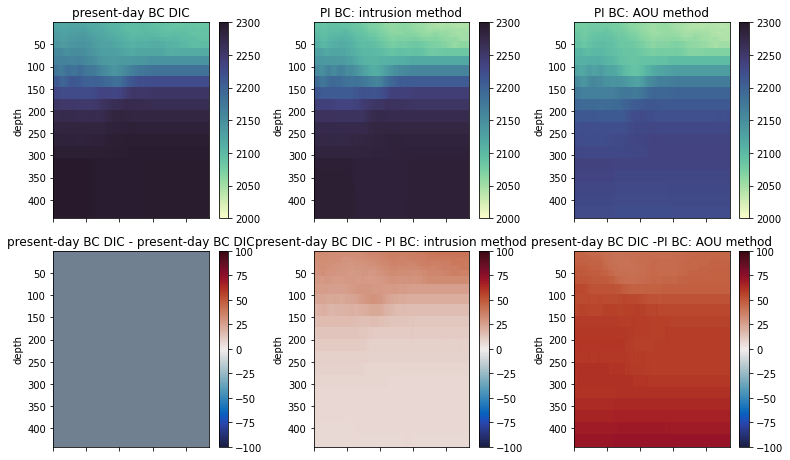

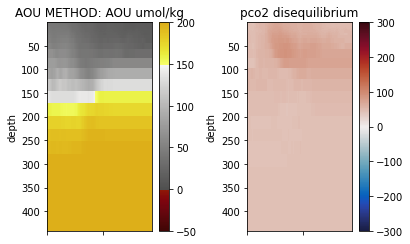

In [23]:

loDIC = LO_DIC['DIC'][0,:,0,:]
iDIC_n = intrusion_DIC_new['preindustrial_DIC']['preind_dic'][:]
ADIC_n = AOU_DIC_new['preindustrial_DIC']['preind_dic'][:]

test_LO = nc.Dataset('/results/forcing/LiveOcean/boundary_conditions/LiveOcean_v201905_y2018m01d01.nc')
zlevels = (test_LO['deptht'][:])

fig = plt.figure(figsize=(11,6.5))
nop = 6
for i in range(1,nop+1):

    if i == 1:
        ax = fig.add_subplot(2,3,i)
        section_slice = np.arange(0, 95)
        sd = (loDIC)
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.deep
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=2000, vmax=2300)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('present-day BC DIC') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([])
        
    if i == 2:
        ax = fig.add_subplot(2,3,i)
        section_slice = np.arange(0, 95)
        sd = (iDIC_n)
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.deep
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=2000, vmax=2300)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('PI BC: intrusion method') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([])
        
    if i == 3:
        ax = fig.add_subplot(2,3,i)
        section_slice = np.arange(0, 95)
        sd = (ADIC_n)
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.deep
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=2000, vmax=2300)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('PI BC: AOU method') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([])   

    if i == 4:
        ax = fig.add_subplot(2,3,i)
        section_slice = np.arange(0, 95)
        sd = (loDIC - loDIC)
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.balance
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=-100, vmax=100)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('present-day BC DIC - present-day BC DIC') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([])
        
    if i == 5:
        ax = fig.add_subplot(2,3,i)
        section_slice = np.arange(0, 95)
        sd = (loDIC - iDIC_n)
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.balance
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=-100, vmax=100)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('present-day BC DIC - PI BC: intrusion method') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([])
        
    if i == 6:
        ax = fig.add_subplot(2,3,i)
        section_slice = np.arange(0, 95)
        sd = (loDIC - ADIC_n)
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.balance
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=-100, vmax=100)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('present-day BC DIC -PI BC: AOU method') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([]) 

plt.tight_layout()

AOU = AOU_DIC_new['preindustrial_DIC']['AOU'][:]
diseq_pco2 = AOU_DIC_new['preindustrial_DIC']['preformed_pco2'][:] - \
AOU_DIC_new['preindustrial_DIC']['pycnal_witnessed_atm_co2'][:]
print('Max diseq pco2: '+str(np.max(diseq_pco2)))
print('Min diseq pco2: '+str(np.min(diseq_pco2)))
fig = plt.figure(figsize=(11,3.5))
nop = 4
for i in range(1,nop+1):

    if i == 1:
        ax = fig.add_subplot(1,4,i)
        section_slice = np.arange(0, 95)
        sd = (AOU)
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.oxy
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=-50, vmax=200)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('AOU METHOD: AOU umol/kg') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([])
        
    if i == 2:
        ax = fig.add_subplot(1,4,i)
        section_slice = np.arange(0, 95)
        sd = (diseq_pco2)
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.balance
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=-300, vmax=300)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('pco2 disequilibrium') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([])

plt.tight_layout()

<div style=”page-break-after: always;”></div>

# yday = 'y2015m04d11'

In [20]:
yday = 'y2015m04d11'
intrusion_DIC_new = nc.Dataset(f'/data/tjarniko/MEOPAR/analysis-tereza/notebooks/carbon_dev/PI_BOUND_COND/CLEAN/preind_DIC/intrusion/LO_intrusion_{yday}_preind_DIC.nc')
AOU_DIC_new = nc.Dataset(f'//data/tjarniko/MEOPAR/analysis-tereza-hg/notebooks/carbon_dev/PI_CARBON_PAPER/PI_BOUND_COND/CLEAN/preind_DIC/diseq/LO_AOUmethod_stoicCO_diseq_{yday}_preind_DIC.nc')
LO_DIC = nc.Dataset(f'/results/forcing/LiveOcean/boundary_conditions/LiveOcean_v201905_{yday}.nc')
loDIC = LO_DIC['DIC'][0,:,0,:]
iDIC_n = intrusion_DIC_new['preindustrial_DIC']['preind_dic'][:]
ADIC_n = AOU_DIC_new['preindustrial_DIC']['preind_dic'][:]

test_LO = nc.Dataset('/results/forcing/LiveOcean/boundary_conditions/LiveOcean_v201905_y2018m01d01.nc')
zlevels = (test_LO['deptht'][:])

fig = plt.figure(figsize=(11,6.5))
nop = 6
for i in range(1,nop+1):

    if i == 1:
        ax = fig.add_subplot(2,3,i)
        section_slice = np.arange(0, 95)
        sd = (loDIC)
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.deep
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=2000, vmax=2300)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('present-day BC DIC') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([])
        
    if i == 2:
        ax = fig.add_subplot(2,3,i)
        section_slice = np.arange(0, 95)
        sd = (iDIC_n)
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.deep
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=2000, vmax=2300)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('PI BC: intrusion method') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([])
        
    if i == 3:
        ax = fig.add_subplot(2,3,i)
        section_slice = np.arange(0, 95)
        sd = (ADIC_n)
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.deep
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=2000, vmax=2300)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('PI BC: AOU method') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([])   

    if i == 4:
        ax = fig.add_subplot(2,3,i)
        section_slice = np.arange(0, 95)
        sd = (loDIC - loDIC)
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.balance
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=-100, vmax=100)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('present-day BC DIC - present-day BC DIC') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([])
        
    if i == 5:
        ax = fig.add_subplot(2,3,i)
        section_slice = np.arange(0, 95)
        sd = (loDIC - iDIC_n)
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.balance
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=-100, vmax=100)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('present-day BC DIC - PI BC: intrusion method') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([])
        
    if i == 6:
        ax = fig.add_subplot(2,3,i)
        section_slice = np.arange(0, 95)
        sd = (loDIC - ADIC_n)
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.balance
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=-100, vmax=100)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('present-day BC DIC -PI BC: AOU method') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([]) 

plt.tight_layout()

AOU = AOU_DIC_new['preindustrial_DIC']['AOU'][:]
diseq_pco2 = AOU_DIC_new['preindustrial_DIC']['preformed_pco2'][:] - \
AOU_DIC_new['preindustrial_DIC']['pycnal_witnessed_atm_co2'][:]
print('Max diseq pco2: '+str(np.max(diseq_pco2)))
print('Min diseq pco2: '+str(np.min(diseq_pco2)))
fig = plt.figure(figsize=(11,3.5))
nop = 4
for i in range(1,nop+1):

    if i == 1:
        ax = fig.add_subplot(1,4,i)
        section_slice = np.arange(0, 95)
        sd = (AOU)
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.oxy
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=-50, vmax=200)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('AOU METHOD: AOU umol/kg') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([])
        
    if i == 2:
        ax = fig.add_subplot(1,4,i)
        section_slice = np.arange(0, 95)
        sd = (diseq_pco2)
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.balance
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=-300, vmax=300)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('pco2 disequilibrium') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([])

plt.tight_layout()

FileNotFoundError: [Errno 2] No such file or directory: b'/data/tjarniko/MEOPAR/analysis-tereza/notebooks/carbon_dev/PI_BOUND_COND/CLEAN/preind_DIC/intrusion/LO_intrusion_y2015m04d11_preind_DIC.nc'

<div style=”page-break-after: always;”></div>

# yday = 'y2015m07d20'

In [ ]:
yday = 'y2015m07d20'
intrusion_DIC_new = nc.Dataset(f'/data/tjarniko/MEOPAR/analysis-tereza/notebooks/carbon_dev/PI_BOUND_COND/CLEAN/preind_DIC/intrusion/LO_intrusion_{yday}_preind_DIC.nc')
AOU_DIC_new = nc.Dataset(f'/data/tjarniko/MEOPAR/analysis-tereza/notebooks/carbon_dev/PI_BOUND_COND/CLEAN/preind_DIC/diseq/LO_AOUmethod_stoicCO_diseq_{yday}_preind_DIC.nc')
LO_DIC = nc.Dataset(f'/results/forcing/LiveOcean/boundary_conditions/LiveOcean_v201905_{yday}.nc')
loDIC = LO_DIC['DIC'][0,:,0,:]
iDIC_n = intrusion_DIC_new['preindustrial_DIC']['preind_dic'][:]
ADIC_n = AOU_DIC_new['preindustrial_DIC']['preind_dic'][:]

test_LO = nc.Dataset('/results/forcing/LiveOcean/boundary_conditions/LiveOcean_v201905_y2018m01d01.nc')
zlevels = (test_LO['deptht'][:])

fig = plt.figure(figsize=(11,6.5))
nop = 6
for i in range(1,nop+1):

    if i == 1:
        ax = fig.add_subplot(2,3,i)
        section_slice = np.arange(0, 95)
        sd = (loDIC)
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.deep
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=2000, vmax=2300)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('present-day BC DIC') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([])
        
    if i == 2:
        ax = fig.add_subplot(2,3,i)
        section_slice = np.arange(0, 95)
        sd = (iDIC_n)
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.deep
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=2000, vmax=2300)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('PI BC: intrusion method') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([])
        
    if i == 3:
        ax = fig.add_subplot(2,3,i)
        section_slice = np.arange(0, 95)
        sd = (ADIC_n)
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.deep
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=2000, vmax=2300)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('PI BC: AOU method') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([])   

    if i == 4:
        ax = fig.add_subplot(2,3,i)
        section_slice = np.arange(0, 95)
        sd = (loDIC - loDIC)
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.balance
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=-100, vmax=100)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('present-day BC DIC - present-day BC DIC') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([])
        
    if i == 5:
        ax = fig.add_subplot(2,3,i)
        section_slice = np.arange(0, 95)
        sd = (loDIC - iDIC_n)
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.balance
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=-100, vmax=100)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('present-day BC DIC - PI BC: intrusion method') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([])
        
    if i == 6:
        ax = fig.add_subplot(2,3,i)
        section_slice = np.arange(0, 95)
        sd = (loDIC - ADIC_n)
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.balance
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=-100, vmax=100)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('present-day BC DIC -PI BC: AOU method') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([]) 

plt.tight_layout()

AOU = AOU_DIC_new['preindustrial_DIC']['AOU'][:]
diseq_pco2 = AOU_DIC_new['preindustrial_DIC']['preformed_pco2'][:] - \
AOU_DIC_new['preindustrial_DIC']['pycnal_witnessed_atm_co2'][:]
print('Max diseq pco2: '+str(np.max(diseq_pco2)))
print('Min diseq pco2: '+str(np.min(diseq_pco2)))
fig = plt.figure(figsize=(11,3.5))
nop = 4
for i in range(1,nop+1):

    if i == 1:
        ax = fig.add_subplot(1,4,i)
        section_slice = np.arange(0, 95)
        sd = (AOU)
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.oxy
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=-50, vmax=200)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('AOU METHOD: AOU umol/kg') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([])
        
    if i == 2:
        ax = fig.add_subplot(1,4,i)
        section_slice = np.arange(0, 95)
        sd = (diseq_pco2)
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.balance
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=-300, vmax=300)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('pco2 disequilibrium') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([])

plt.tight_layout()

<div style=”page-break-after: always;”></div>

# yday = 'y2015m10d30'

In [ ]:
yday = 'y2015m10d30'
intrusion_DIC_new = nc.Dataset(f'/data/tjarniko/MEOPAR/analysis-tereza/notebooks/carbon_dev/PI_BOUND_COND/CLEAN/preind_DIC/intrusion/LO_intrusion_{yday}_preind_DIC.nc')
AOU_DIC_new = nc.Dataset(f'/data/tjarniko/MEOPAR/analysis-tereza/notebooks/carbon_dev/PI_BOUND_COND/CLEAN/preind_DIC/diseq/LO_AOUmethod_stoicCO_diseq_{yday}_preind_DIC.nc')
LO_DIC = nc.Dataset(f'/results/forcing/LiveOcean/boundary_conditions/LiveOcean_v201905_{yday}.nc')
loDIC = LO_DIC['DIC'][0,:,0,:]
iDIC_n = intrusion_DIC_new['preindustrial_DIC']['preind_dic'][:]
ADIC_n = AOU_DIC_new['preindustrial_DIC']['preind_dic'][:]

test_LO = nc.Dataset('/results/forcing/LiveOcean/boundary_conditions/LiveOcean_v201905_y2018m01d01.nc')
zlevels = (test_LO['deptht'][:])

fig = plt.figure(figsize=(11,6.5))
nop = 6
for i in range(1,nop+1):

    if i == 1:
        ax = fig.add_subplot(2,3,i)
        section_slice = np.arange(0, 95)
        sd = (loDIC)
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.deep
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=2000, vmax=2300)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('present-day BC DIC') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([])
        
    if i == 2:
        ax = fig.add_subplot(2,3,i)
        section_slice = np.arange(0, 95)
        sd = (iDIC_n)
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.deep
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=2000, vmax=2300)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('PI BC: intrusion method') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([])
        
    if i == 3:
        ax = fig.add_subplot(2,3,i)
        section_slice = np.arange(0, 95)
        sd = (ADIC_n)
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.deep
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=2000, vmax=2300)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('PI BC: AOU method') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([])   

    if i == 4:
        ax = fig.add_subplot(2,3,i)
        section_slice = np.arange(0, 95)
        sd = (loDIC - loDIC)
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.balance
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=-100, vmax=100)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('present-day BC DIC - present-day BC DIC') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([])
        
    if i == 5:
        ax = fig.add_subplot(2,3,i)
        section_slice = np.arange(0, 95)
        sd = (loDIC - iDIC_n)
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.balance
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=-100, vmax=100)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('present-day BC DIC - PI BC: intrusion method') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([])
        
    if i == 6:
        ax = fig.add_subplot(2,3,i)
        section_slice = np.arange(0, 95)
        sd = (loDIC - ADIC_n)
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.balance
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=-100, vmax=100)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('present-day BC DIC -PI BC: AOU method') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([]) 

plt.tight_layout()

AOU = AOU_DIC_new['preindustrial_DIC']['AOU'][:]
diseq_pco2 = AOU_DIC_new['preindustrial_DIC']['preformed_pco2'][:] - \
AOU_DIC_new['preindustrial_DIC']['pycnal_witnessed_atm_co2'][:]
print('Max diseq pco2: '+str(np.max(diseq_pco2)))
print('Min diseq pco2: '+str(np.min(diseq_pco2)))
fig = plt.figure(figsize=(11,3.5))
nop = 4
for i in range(1,nop+1):

    if i == 1:
        ax = fig.add_subplot(1,4,i)
        section_slice = np.arange(0, 95)
        sd = (AOU)
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.oxy
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=-50, vmax=200)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('AOU METHOD: AOU umol/kg') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([])
        
    if i == 2:
        ax = fig.add_subplot(1,4,i)
        section_slice = np.arange(0, 95)
        sd = (diseq_pco2)
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.balance
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=-300, vmax=300)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('pco2 disequilibrium') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([])

plt.tight_layout()

<div style=”page-break-after: always;”></div>

In [ ]:
def DIC_from_s_t_AOU(DIC, TA, sal,temp,AOU):
    
    sigma0 = gsw.sigma0(sal,temp)
    params0 = 0.1301889490932413
    params1 = 3.8509914822057825
    params2 = 8.301166081413104
    pycnal_age = (params0 *np.exp(-params1*(25.15-sigma0))+params2)
    pycnal_last_at_surface = 2019 - (params0 *np.exp(-params1*(25.15-sigma0))+params2)
    pycnal_witnessed_atm_co2 = np.zeros_like(pycnal_last_at_surface)
    ty = pycnal_last_at_surface
    tco2 = co2_from_year(ty)
    pycnal_witnessed_atm_co2 = tco2
    preformed_DIC = DIC - AOU
    tsra_psu = sal*35/35.16504
    ttera_is = gsw.t_from_CT(sal,temp,0)

    response_tup = mocsy.mvars(temp=temp, sal=sal, alk=TA* 1e-3, dic=preformed_DIC* 1e-3, 
                       sil=0, phos=0, patm=0, depth=0, lat=0, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup
    preformed_pco2 = pco2
    diseqPCO2 = preformed_pco2 - pycnal_witnessed_atm_co2
    #print('diseqPCO2: '+str(diseqPCO2))
    pref_pco2_inc_diseqpco2 = diseqPCO2 + preformed_pco2
    preind_dic = find_DIC_corresp_to_pco2(sal, temp, pref_pco2_inc_diseqpco2, TA, 1, 0)
#     print(DIC)
#     print(preind_dic)
    return preind_dic, pycnal_age

def DIC_from_s_t_AOU_stoich(DIC, TA, sal,temp,AOU):
    
    sigma0 = gsw.sigma0(sal,temp)
    params0 = 0.1301889490932413
    params1 = 3.8509914822057825
    params2 = 8.301166081413104
    pycnal_age = (params0 *np.exp(-params1*(25.15-sigma0))+params2)
    pycnal_last_at_surface = 2019 - (params0 *np.exp(-params1*(25.15-sigma0))+params2)
    pycnal_witnessed_atm_co2 = np.zeros_like(pycnal_last_at_surface)
    ty = pycnal_last_at_surface
    tco2 = co2_from_year(ty)
    pycnal_witnessed_atm_co2 = tco2
    preformed_DIC = DIC - AOU*(117/170)
    tsra_psu = sal*35/35.16504
    ttera_is = gsw.t_from_CT(sal,temp,0)

    response_tup = mocsy.mvars(temp=temp, sal=sal, alk=TA* 1e-3, dic=preformed_DIC* 1e-3, 
                       sil=0, phos=0, patm=0, depth=0, lat=0, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup
    
    preformed_pco2 = pco2
    
    diseqPCO2 = preformed_pco2 - pycnal_witnessed_atm_co2
    #print('diseqPCO2: '+str(diseqPCO2))
    #pref_pco2_inc_diseqpco2 = diseqPCO2 + preformed_pco2
    pref_pco2_inc_diseqpco2 = diseqPCO2 + 284
    preind_pref_dic = find_DIC_corresp_to_pco2(sal, temp, pref_pco2_inc_diseqpco2, TA, 1, 0)
    preind_dic = DIC - (preformed_DIC- preind_pref_dic)
#     print(DIC)
#     print(preind_dic)
    return preind_dic, pycnal_age

def DIC_from_s_t_intrusion(DIC, TA, sal,temp, AOU):
    
    sigma0 = gsw.sigma0(sal,temp)
    params0 = 0.1301889490932413
    params1 = 3.8509914822057825
    params2 = 8.301166081413104
    pycnal_age = (params0 *np.exp(-params1*(25.15-sigma0))+params2)
    pycnal_last_at_surface = 2019 - (params0 *np.exp(-params1*(25.15-sigma0))+params2)
    pycnal_witnessed_atm_co2 = np.zeros_like(pycnal_last_at_surface)
    ty = pycnal_last_at_surface
    tco2 = co2_from_year(ty)
    pycnal_witnessed_atm_co2 = tco2
    pycnal_intrusion = pycnal_witnessed_atm_co2 - 284
    
    tsra_psu = sal*35/35.16504
    ttera_is = gsw.t_from_CT(sal,temp,0)

    response_tup = mocsy.mvars(temp=temp, sal=sal, alk=TA* 1e-3, dic=DIC* 1e-3, 
                       sil=0, phos=0, patm=0, depth=0, lat=0, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup
    insitu_pco2 = pco2
    preind_pco2 = insitu_pco2 - pycnal_intrusion
    preind_dic = find_DIC_corresp_to_pco2(sal, temp, preind_pco2, TA, 1, 0)
#     print(DIC)
#     print(preind_dic)
    return preind_dic, pycnal_age

def find_pycnal_age(sal,temp):
    
    sigma0 = gsw.sigma0(sal,temp)
    params0 = 0.1301889490932413
    params1 = 3.8509914822057825
    params2 = 8.301166081413104
    pycnal_age = (params0 *np.exp(-params1*(25.15-sigma0))+params2)
    
    return(pycnal_age)

In [ ]:

AOU = 130
s = 29
t = 7
preind_dic, pycnal_age = DIC_from_s_t_AOU(2200, 2200, s,t,AOU)
preind_dic, pycnal_age = DIC_from_s_t_intrusion(2200, 2200, s,t,AOU)
print(pycnal_age)

DIC = np.arange(2100,2300,10)
TA = np.zeros_like(DIC)
TA[:] = 2250
s = np.zeros_like(DIC)
t = np.zeros_like(DIC)
s[:] = 29
t[:] = 7
preind_DIC_AOU =np.zeros_like(DIC)
preind_DIC_intrusion = np.zeros_like(DIC)

for i in range(0, len(preind_DIC_AOU)):
    t_DIC = DIC[i]
    t_TA = TA[i]
    t_s = s[i]
    t_t = t[i]
    dic, w = DIC_from_s_t_AOU(t_DIC, 2250, 29,7,50)
    
    preind_DIC_AOU[i] = dic
    dic, w = DIC_from_s_t_intrusion(t_DIC, 2250, 29,7,50)
    preind_DIC_intrusion[i] = dic
    
    
# plt.plot(DIC,preind_DIC_AOU)
# plt.plot(DIC,preind_DIC_intrusion)

In [ ]:
las = intrusion_DIC_new['preindustrial_DIC']['pycnal_last_at_surface']
sigthet = intrusion_DIC_new['preindustrial_DIC']['sigma0']
print(np.max(las))
print(np.max(sigthet))

In [ ]:
# print(s)
# print(t)
# w = find_pycnal_age(5,5)

# 'T = 6, S varies accordingly, TA = 2250' 

In [ ]:
fig = plt.figure(figsize=(11,11))
nop = 9
AOU = [-50,-50,-50,50,50,50,150,150,150]
s_vec = [32.954, 34.013, 34.5175,32.954, 34.013, 34.5175,32.954, 34.013, 34.5175]

for i in range(1,nop+1):
    ax = fig.add_subplot(3,3,i)
    t = 6
    s = s_vec[i-1]
    t_AOU = AOU[i-1]
    pycag = find_pycnal_age(s,t)
    ax.set_title('AOU: '+str(int(t_AOU)) + ', water age: '+ str(int(pycag)))
    
    DIC = np.arange(2000,2300,10)
    preind_DIC_AOU =np.zeros_like(DIC)
    preind_DIC_AOU_stoich =np.zeros_like(DIC)
    preind_DIC_intrusion = np.zeros_like(DIC)

    for d in range(0, len(preind_DIC_AOU)):
        t_DIC = DIC[d]
        dic, w = DIC_from_s_t_AOU(t_DIC, 2250, s,t,t_AOU)
        preind_DIC_AOU[d] = dic
        dic, w = DIC_from_s_t_intrusion(t_DIC, 2250, s,t,t_AOU)
        preind_DIC_intrusion[d] = dic
        dic, w = DIC_from_s_t_AOU_stoich(t_DIC, 2250, s,t,t_AOU)
        preind_DIC_AOU_stoich[d] = dic
    #ax.plot(DIC,preind_DIC_AOU,'-b',label = 'AOU method')
    ax.plot(DIC,preind_DIC_AOU_stoich,':b',label = 'AOU method (stoich C:O)')
    ax.plot(DIC,preind_DIC_intrusion,'-r',label = 'intrusion method')
    ax.set_xlabel('present_day DIC')
    ax.set_ylabel('preindustrial DIC')
    if i == 1:
        ax.legend()

plt.tight_layout()
#plt.suptitle('T = 6, S varies accordingly, TA = 2250')

<div style=”page-break-after: always;”></div>

# 'T = 6, S varies accordingly, TA = 2350' 

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(9,9))
nop = 9
AOU = [-50,-50,-50,50,50,50,150,150,150]
s_vec = [32.954, 34.013, 34.5175,32.954, 34.013, 34.5175,32.954, 34.013, 34.5175]

for i in range(1,nop+1):
    ax = fig.add_subplot(3,3,i)
    t = 6
    s = s_vec[i-1]
    t_AOU = AOU[i-1]
    pycag = find_pycnal_age(s,t)
    ax.set_title('AOU: '+str(int(t_AOU)) + ', water age: '+ str(int(pycag)))
    
    DIC = np.arange(2000,2300,10)
    preind_DIC_AOU =np.zeros_like(DIC)
    preind_DIC_AOU_stoich =np.zeros_like(DIC)
    preind_DIC_intrusion = np.zeros_like(DIC)

    for d in range(0, len(preind_DIC_AOU)):
        t_DIC = DIC[d]
        dic, w = DIC_from_s_t_AOU(t_DIC, 2350, s,t,t_AOU)
        preind_DIC_AOU[d] = dic
        dic, w = DIC_from_s_t_intrusion(t_DIC, 2350, s,t,t_AOU)
        preind_DIC_intrusion[d] = dic
        dic, w = DIC_from_s_t_AOU_stoich(t_DIC, 2350, s,t,t_AOU)
        preind_DIC_AOU_stoich[d] = dic
    #ax.plot(DIC,preind_DIC_AOU,'-b',label = 'AOU method')
    ax.plot(DIC,preind_DIC_AOU_stoich,':b',label = 'AOU method (stoich C:O)')
    ax.plot(DIC,preind_DIC_intrusion,'-r',label = 'intrusion method')
    ax.set_xlabel('present_day DIC')
    ax.set_ylabel('preindustrial DIC')
    if i == 1:
        ax.legend()

plt.tight_layout()
#plt.suptitle('T = 6, S varies accordingly, TA = 2250')

In [ ]:
# s_vec = 32.954, 34.013, 34.5175
# s = 32.954
# t = 6
# preind_dic, pycnal_age = DIC_from_s_t_AOU(2200, 2200, s,t,AOU)
# print(pycnal_age)

# print('')
# s = 34.013
# t = 6
# preind_dic, pycnal_age = DIC_from_s_t_AOU(2200, 2200, s,t,AOU)
# print(pycnal_age)

# print('')
# s = 34.5175
# t = 6
# preind_dic, pycnal_age = DIC_from_s_t_AOU(2200, 2200, s,t,AOU)
# print(pycnal_age)

In [ ]:
response_tup = mocsy.mvars(temp=7, sal=29, alk=2300*1e-3, dic=2230*1e-3, 
                       sil=0, phos=0, patm=0, depth=0, lat=0, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup    
print(pco2)   

In [ ]:
print(pco2)

In [ ]:
m = ['01','02','03','04','05','06','07','08','09','10','11','12']
yday_list = []
for i in range(0,12):
    t_yday = 'y2015m' + m[i] + 'd15'
    yday_list.append(t_yday)

yday = 'y2015m01d15'
intrusion_DIC_new = nc.Dataset(f'/data/tjarniko/MEOPAR/analysis-tereza/notebooks/carbon_dev/PI_BOUND_COND/CLEAN/preind_DIC/intrusion/LO_intrusion_{yday}_preind_DIC.nc')
AOU_DIC_new = nc.Dataset(f'/data/tjarniko/MEOPAR/analysis-tereza/notebooks/carbon_dev/PI_BOUND_COND/CLEAN/preind_DIC/AOU_nozero/LO_AOUmethod_notzeroed_{yday}_preind_DIC.nc')
LO_DIC = nc.Dataset(f'/results/forcing/LiveOcean/boundary_conditions/LiveOcean_v201905_{yday}.nc')
loDIC = LO_DIC['DIC'][0,:,0,:]
iDIC_n = intrusion_DIC_new['preindustrial_DIC']['preind_dic'][:]
ADIC_n = AOU_DIC_new['preindustrial_DIC']['preind_dic'][:]

test_LO = nc.Dataset('/results/forcing/LiveOcean/boundary_conditions/LiveOcean_v201905_y2018m01d01.nc')
zlevels = (test_LO['deptht'][:])

fig = plt.figure(figsize=(11,6.5))
nop = 24
for i in range(1,nop+1):
    if i<13:
        yday = yday_list[i-1]
    if i>12:
        yday = yday_list[i-13]

    intrusion_DIC_new = nc.Dataset(f'/data/tjarniko/MEOPAR/analysis-tereza/notebooks/carbon_dev/PI_BOUND_COND/CLEAN/preind_DIC/intrusion/LO_intrusion_{yday}_preind_DIC.nc')
    AOU_DIC_new = nc.Dataset(f'/data/tjarniko/MEOPAR/analysis-tereza/notebooks/carbon_dev/PI_BOUND_COND/CLEAN/preind_DIC/diseq/LO_AOUmethod_stoicCO_diseq_{yday}_preind_DIC.nc')
    LO_DIC = nc.Dataset(f'/results/forcing/LiveOcean/boundary_conditions/LiveOcean_v201905_{yday}.nc')
    loDIC = LO_DIC['DIC'][0,:,0,:]
    iDIC_n = intrusion_DIC_new['preindustrial_DIC']['preind_dic'][:]
    ADIC_n = AOU_DIC_new['preindustrial_DIC']['preind_dic'][:]

    test_LO = nc.Dataset('/results/forcing/LiveOcean/boundary_conditions/LiveOcean_v201905_y2018m01d01.nc')
    zlevels = (test_LO['deptht'][:])
    
    ax = fig.add_subplot(2,12,i)
    section_slice = np.arange(0, 95)
    if i <13:
        sd = (loDIC - iDIC_n)
        ax.set_title('month: '+str(m[i-1]))
    if i >12:
        sd = (loDIC - ADIC_n)
        ax.set_title('month: '+str(m[i-13]))
    tplt = np.ma.masked_values(sd,0)
    tcmap = cm.cm.balance
    cmap = tcmap
    mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=-100, vmax=100)
    if (i == 12) | (i == 24):
        cbar = fig.colorbar(mesh, ax=ax)
    ax.invert_yaxis()
    land_colour = 'slategrey'
    cmap.set_bad(land_colour)
    
    if i == 1:
        ax.set_ylabel('depth')
    if ((i != 1)):
        ax.set_yticklabels([])
    ax.set_xticklabels([])